In [1]:
import sys
import csv
import re
import pprint
import fastText
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from bs4 import BeautifulSoup
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
# Test parts for data preparation; not used eventually
# from nltk.corpus import stopwords
# stop_words = stopwords.words("dutch")
#         tweet = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", tweet).split()) # remove hastags and mentions
#         tweet = ' '.join(re.sub("[\'\.\,\!\?\:\;\-\=\(\)\[\]\{\}\\\<\>\/\?\@\#$#\%\^\&\*\_\~\"]", " ", tweet).split()) # remove punctuation
#         tweet = remove_emoji(tweet)
#     df["cleaned"] = df["cleaned"].str.split()
#     df["cleaned"].apply(lambda x: [item for item in x if item not in stop_words]) # remove stopwords
#     df["cleaned"] = [" ".join(x) for x in df["cleaned"]]

# Prepare data

In [3]:
def preprocess(df):
    df["cleaned"] = ""
    processed_text = []
    for text in df["text"]:
        text = BeautifulSoup(text).get_text() # transforms things like &amp to &
        text = text.lower()
        text = ' '.join(re.sub("(?<=@)\w+", "MENTION", text).split()) # replace mentions with "MENTION" in tweets
        text = ' '.join(re.sub("(\/u\/[A-Za-z0-9]+)", "MENTION", text).split()) # replace mentions with "MENTION" in Reddit Comments. Example: /u/username
        text = ' '.join(re.sub("(u\/[A-Za-z0-9]+)", "MENTION", text).split()) # replace mentions with "MENTION" in Reddit Comments. Example: u/username
        text = ' '.join(re.sub("#", " ", text).split()) # remove # symbols    
        text = ' '.join(re.sub("(\w+:\/\/\S+)", "URL", text).split()) # replace links/URLs with "URL"
        processed_text.append(text)
         
    df["cleaned"] = processed_text

    return df["cleaned"]

def replacer(input_file):
    df = pd.read_csv(input_file, sep='\t', encoding="utf8")
    df["cleaned"] = preprocess(df) # add processed text to a new column "cleaned" and add this to the dataframe
    
    # replace all EXPLICIT and IMPLICIT labels with OFFENSIVE
    df["explicitness"] = df["explicitness"].replace(["EXPLICIT", "IMPLICIT"], "OFFENSIVE")

    print(df["explicitness"].value_counts())
    
    # transform labels with LabelEncoder
    # 0 = NOT
    # 1 = OFFENSIVE
    df["explicitness"] = df["explicitness"].astype(str)
    df["explicitness"] = LabelEncoder().fit_transform(df["explicitness"])

    return df       

In [4]:
print("Train:")
train_df = replacer("train_final.csv")

print("Dev:")
dev_df = replacer("dev_final.csv")

print("Test:")
test_df = replacer("test_final.csv")

print(train_df["text"].head())
print(train_df["cleaned"].head())

Train:
NOT          5176
OFFENSIVE    2588
Name: explicitness, dtype: int64
Dev:
NOT          361
OFFENSIVE    186
Name: explicitness, dtype: int64
Test:
NOT          2072
OFFENSIVE    1036
Name: explicitness, dtype: int64
0    @StuiverAnne @LodewijkA Iets anders, wanneer w...
1    @GUnight fucking schaamteloos! Je kunt de Afri...
2    Mijn hemel! De elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    @GerardKrolNL @groenlinks het is goed te zien ...
Name: text, dtype: object
0    @MENTION @MENTION iets anders, wanneer word as...
1    @MENTION fucking schaamteloos! je kunt de afri...
2    mijn hemel! de elite, diegenen die onze cultuu...
3    het feit dat mensen nog steeds zwarte piet sup...
4    @MENTION @MENTION het is goed te zien dat grli...
Name: cleaned, dtype: object


In [5]:
# vectorize words using tf_idf for SVM
tf_idf = TfidfVectorizer()
# print(tf_idf.get_feature_names())
X_train = pd.DataFrame(tf_idf.fit_transform(train_df["cleaned"]).toarray())

tf_idf2 = TfidfVectorizer(vocabulary = tf_idf.get_feature_names())
X_test = pd.DataFrame(tf_idf2.fit_transform(test_df["cleaned"]).toarray())

print(X_train.shape)
print(X_test.shape)

(7764, 20385)
(3108, 20385)


# Apply LinearSVC

In [29]:
np.random.seed(1)

y_train = train_df["explicitness"].copy()

y_test = test_df["explicitness"].copy()

model = svm.LinearSVC(loss="hinge")

model.fit(X_train, y_train)
print(f"SVC accuracy: {model.score(X_test, y_test):.2f}") # 0.8104890604890604

SVC_f1 = f1_score(y_test, model.predict(X_test), average='macro') # 0.7706758379027286
print(f"SVC macro f1-score: {SVC_f1:.2f}")

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

SVC accuracy: 0.81
SVC macro f1-score: 0.77
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      2072
           1       0.79      0.59      0.68      1036

    accuracy                           0.81      3108
   macro avg       0.80      0.76      0.77      3108
weighted avg       0.81      0.81      0.80      3108



In [30]:
print("The paramaters used for the LinearSVC model are:\n")
model.get_params()

The paramaters used for the LinearSVC model are:



{'C': 1.0,
 'class_weight': None,
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

[[1907  165]
 [ 424  612]]


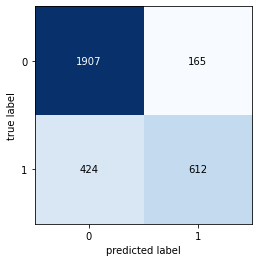

In [31]:
y_target = y_test
y_predicted = y_pred

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)
print(cm)

fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

# Add prefix to work with fasttext

In [6]:
def add_prefix(dataframe, output_file):

    f_rows = []

    # add required prefix for fasttext
    for index, row in dataframe.iterrows():
        fasttext_row = f"{'__label__' + str(row['explicitness'])} {row['cleaned']}"
        f_rows.append(fasttext_row)
        
    fasttext_df = pd.DataFrame(f_rows)
    
    return fasttext_df.to_csv(output_file, index=False, header=False, encoding="utf-8", 
                              quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ")

In [33]:
print("Adding prefixes to data...")
fasttext_df_train = add_prefix(train_df, 'train.txt')
fasttext_df_dev = add_prefix(dev_df, 'dev.txt')
fasttext_df_test = add_prefix(test_df, 'test.txt')
print("Done!")

Adding prefixes to data...
Done!


# Train fastText model

In [7]:
# print("Training fasttext model...")
# f_model = fastText.train_supervised(input="train.txt",  
#                                     autotuneValidationFile="dev.txt", 
#                                     autotuneMetric="f1:__label__1", 
#                                     autotuneDuration=300)
# print("Done! Saving the model now...")
# f_model.save_model("fasttext_model_binary.bin")
# print("The model is saved as 'fasttext_model_binary.bin'.")

print("Loading fasttext model...")
f_model = fastText.load_model("fasttext_model_binary.bin")
print("Model loaded succesfully!")

# the part below is used to print out the arguments of the autotunoValidation
print("The paramaters used for the fastText model are:\n")
args_obj = f_model.f.getArgs()
for hparam in dir(args_obj):
    if not hparam.startswith('__'):
        print(f"{hparam} -> {getattr(args_obj, hparam)}")

Loading fasttext model...
Model loaded succesfully!
The paramaters used for the fastText model are:

autotuneDuration -> 300
autotuneMetric -> f1
autotuneModelSize -> 
autotunePredictions -> 1
autotuneValidationFile -> 
bucket -> 3869285
cutoff -> 0
dim -> 199
dsub -> 2
epoch -> 9
input -> 
label -> __label__
loss -> loss_name.softmax
lr -> 0.05
lrUpdateRate -> 100
maxn -> 5
minCount -> 1
minCountLabel -> 0
minn -> 2
model -> model_name.supervised
neg -> 5
output -> 
pretrainedVectors -> 
qnorm -> False
qout -> False
retrain -> False
saveOutput -> False
seed -> 0
setManual -> <bound method PyCapsule.setManual of <fasttext_pybind.args object at 0x0000029B713521F0>>
t -> 0.0001
thread -> 12
verbose -> 2
wordNgrams -> 2
ws -> 5


In [37]:
f_model.get_nearest_neighbors("halsema")

[(0.9999803900718689, 'halalsema'),
 (0.9999688863754272, 'gorelinksehalsema'),
 (0.9999602437019348, 'femkehalsema'),
 (0.999958872795105, 'halsema!'),
 (0.9999585151672363, 'halsemaout'),
 (0.9999548196792603, 'shit'),
 (0.9999511241912842, 'shit.'),
 (0.9999502897262573, 'halalsema!'),
 (0.9999496340751648, 'idioot!'),
 (0.9999493956565857, 'tuig')]

In [38]:
# get all labels (k=-1) with probability higher or equal to 0.5 (threshold)
# probabilities such as 1.00000942 occur due to rounding, so these can be seen as 1.0 or 100%
test_sentence = "wij zijn een stel idioten"
f_model.predict(test_sentence,  k=-1, threshold=0.5)

(('__label__1',), array([1.00000942]))

In [39]:
# __label__0 = NOT
# __label__1 = OFFENSIVE

# The precision is the number of correct labels among the labels predicted by fastText. 
# The recall is the number of labels that successfully were predicted, among all the real labels.

results = f_model.test_label("test.txt")
print("Results per label:")
pprint.pprint(results)

# fastText model trained for 10 minutes
# {'__label__0': {'f1score': 0.8690587138863001,
#                 'precision': 0.8400900900900901,
#                 'recall': 0.900096525096525},
#  '__label__1': {'f1score': 0.7079002079002079,
#                 'precision': 0.7668918918918919,
#                 'recall': 0.6573359073359073}}
# fastText model trained for 15 minutes
# {'__label__0': {'f1score': 0.8657988165680474,
#                 'precision': 0.8495123084068741,
#                 'recall': 0.8827220077220077},
#  '__label__1': {'f1score': 0.7152184831742843,
#                 'precision': 0.7455497382198953,
#                 'recall': 0.6872586872586872}}
# fastText model trained for 30 minutes
# {'__label__0': {'f1score': 0.8638914873713751,
#                 'precision': 0.838021778584392,
#                 'recall': 0.8914092664092664},
#  '__label__1': {'f1score': 0.7,
#                 'precision': 0.7511061946902655,
#                 'recall': 0.6554054054054054}}

Results per label:
{'__label__0': {'f1score': 0.8587270973963356,
                'precision': 0.8578998073217726,
                'recall': 0.8595559845559846},
 '__label__1': {'f1score': 0.7166344294003868,
                'precision': 0.7180232558139535,
                'recall': 0.7152509652509652}}


# Test model on reddit comments

In [8]:
reddit_df = pd.read_csv("reddit_comments.csv", sep=',', encoding="utf8")

preprocess(reddit_df)

reddit_df_test = add_prefix(reddit_df, 'reddit_test.txt')

In [9]:
def fasttext_model_test(input_file):

    predictions = []

    with open(input_file, encoding="utf8") as f:
        for line in f:
            # check the text, ignore label if label == nan
            test_sentence = line[14:].rstrip()
            predictions.append(f_model.predict(test_sentence,  k=-1, threshold=0.5))

    return predictions, test_sentence 

In [10]:
# predict labels with fastText
test = fasttext_model_test("reddit_test.txt")

# print(reddit_df["explicitness"])
# add every predicted label to the dataframe by changing 'NaN' to '__label__X' where X is 0 or 1
reddit_df["explicitness"] = [str(label[0])[2:-3] for label in test[0]]
# print(reddit_df["explicitness"])

# save the labels and processed text to a file to check full output
# reddit_df[["explicitness", "cleaned"]].to_csv("reddit_test_labeled.txt", index=False, header=False, encoding="utf-8", 
#                                             quoting = csv.QUOTE_NONE, quotechar = "", escapechar = " ", sep =" ")

reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__1"], "OFFENSIVE")
reddit_df["explicitness"] = reddit_df["explicitness"].replace(["__label__0"], "NOT")

# get 25 random samples for both offensive and not offensive predictions
NOT_sample_df = reddit_df[reddit_df["explicitness"] == "NOT"].sample(n=25, random_state=1)
OFFENSIVE_sample_df = reddit_df[reddit_df["explicitness"] == "OFFENSIVE"].sample(n=25, random_state=1)

reddit_samples_df = pd.concat([NOT_sample_df, OFFENSIVE_sample_df])
reddit_samples_df["annotation"] = ""

reddit_samples_df[["explicitness", "cleaned", "annotation"]].to_csv("reddit_samples.csv", index=False, encoding="utf-8", sep =",")

# label distribution after prediction
print(reddit_df["explicitness"].value_counts())

NOT          394
OFFENSIVE    131
Name: explicitness, dtype: int64


In [11]:
annotated_reddit_samples_df = pd.read_csv("reddit_samples_annotated.csv", sep=',', encoding="utf8")

y_true = annotated_reddit_samples_df["annotation"].copy()
y_pred = annotated_reddit_samples_df["explicitness"].copy()

print(classification_report(y_true, y_pred, labels=["NOT", "OFFENSIVE"]))

              precision    recall  f1-score   support

         NOT       0.60      0.62      0.61        24
   OFFENSIVE       0.64      0.62      0.63        26

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.62      0.62      0.62        50



In [12]:
reddit_cm = confusion_matrix(y_true, y_pred)
print(reddit_cm)

[[15  9]
 [10 16]]


# Calculate out of vocabulary rate

In [13]:
def remove_emoji(string):
    """Used from user saaranshM (https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b)"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

def count_number_of_tokens(df):

    total_sent_length = []
    all_tokens = []

    for i, sent in enumerate(df):
        # punctuation, emoji's and the words MENTION and URL are removed in the token count
        sent = sent.translate(str.maketrans({a: None for a in string.punctuation}))
        sent = remove_emoji(sent)
        tokens = word_tokenize(sent)
        final_tokens = [word for word in tokens if word not in ["MENTION", "URL"]]
        all_tokens += final_tokens
        sent_length = len(final_tokens)
        total_sent_length.append(sent_length)

    unique_tokens = set(all_tokens)
    average_number_of_tokens = (sum(total_sent_length)/len(total_sent_length))
    
    return unique_tokens, average_number_of_tokens

In [20]:
# make word sets for both the twitter train data and reddit data (sample)
tok_tweet_train = count_number_of_tokens(train_df["cleaned"])
tok_reddit = count_number_of_tokens(reddit_df["cleaned"])
tok_reddit_sample = count_number_of_tokens(annotated_reddit_samples_df["cleaned"])

reddit_counter = 0
reddit_sample_counter = 0

# check (lookup) how many tokens from the Reddit data are NOT in the set of the twitter data
different_tokens = len(tok_reddit[0].difference(tok_tweet_train[0]))
different_tokens_sample = len(tok_reddit_sample[0].difference(tok_tweet_train[0]))
        
# calculate out of vocabulary rate
oov1 = different_tokens/len(tok_tweet_train[0])
oov2 = different_tokens_sample/len(tok_tweet_train[0])

print(f"Average length of all Reddit comments: {tok_reddit[1]}")
print(f"Average length of tweets in train data: {tok_tweet_train[1]}\n")

print(f"Out of vocabulary rate all Reddit comments: {oov1}")
print(f"Out of vocabulary rate Reddit comments sample: {oov2}")

Average length of all Reddit comments: 69.08
Average length of tweets in train data: 19.873905203503348

Out of vocabulary rate all Reddit comments: 0.12056136385042855
Out of vocabulary rate Reddit comments sample: 0.014834699067533201
